In [1]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. chia train, val, test (tỉ lệ 70/15/15)
target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)


# Tạo feature engineering
column_lag = ['tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'pressure_temp_index', 'wind_temp_index', 'temp_range', 'dew_spread']

train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
(2562, 246)


In [3]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 245), (2562,)), Val: ((549, 245), (549,)), Test: ((549, 245), (549,))


In [4]:
pipeline2 = pl.build_ExTree_featture_engineering_pipeline(top_k=30)
X_train = pipeline2.fit_transform(X= X_train, y= y_train)

In [5]:
X_val = pipeline2.transform(X= X_val)
X_test = pipeline2.transform(X= X_test)

In [6]:
X_train.columns

Index(['feelslike_lag_1', 'sunrise_lag_1', 'pressure_temp_index_roll_mean_14',
       'sealevelpressure_roll_mean_14', 'dew_roll_mean_3',
       'solar_temp_index_lag_1', 'day_length_lag_1', 'winddir_lag_1',
       'tempmax_lag_3', 'wind_temp_index_roll_mean_14',
       'pressure_temp_index_lag_6', 'dew_lag_5', 'dew_lag_4',
       'month_sin_lag_1', 'uvindex_lag_1', 'windspeed_lag_1',
       'humidity_high_lag_1', 'wind_temp_index_roll_mean_7', 'windgust_lag_1',
       'humidity_lag_1', 'dew_roll_std_14', 'month_lag_1', 'visibility_lag_1',
       'wind_temp_index_lag_1', 'dew_spread_lag_1', 'wind_variability_lag_1',
       'precipprob_lag_1', 'solarradiation_roll_mean_3',
       'windspeed_roll_mean_3', 'windgust_roll_mean_3'],
      dtype='object')

In [ ]:
# chưa có feature selection để nguyên tất cả temp lag 1, 252 feature
# 1. RF
## Default
# a. Validation metrics: {'RMSE': 2.1278075895022885, 'R2': 0.8297628223226209, 'MAPE': 7.013125189028322}
# b. Test metrics: {'RMSE': 1.7168173002419687, 'R2': 0.8638144750921892, 'MAPE': 5.359437239042012}

## Best parameter
# Validation metrics: {'RMSE': 1.6388776242029133, 'R2': 0.8990089808287993, 'MAPE': 5.741406234570231}
# Test metrics: {'RMSE': 1.4337918013739446, 'R2': 0.9050150119360206, 'MAPE': 4.584963631819218}


# 2. Extra Tree
## Default
# Validation metrics: {'RMSE': 1.5501069852687441, 'R2': 0.9096531427481926, 'MAPE': 5.289823867518864}
# Test metrics: {'RMSE': 1.4094799560393934, 'R2': 0.9082088955219491, 'MAPE': 4.494487229026149}

## Best parameter
# Validation metrics: {'RMSE': 1.4981094962144423, 'R2': 0.9156127533286983, 'MAPE': 5.13799909932879}
# Test metrics: {'RMSE': 1.3558239003827515, 'R2': 0.9150644784751033, 'MAPE': 4.317549688535942}

# 3. GB
## Default
# Validation metrics: {'RMSE': 1.479398688181336, 'R2': 0.9177075178532362, 'MAPE': 5.0692414857715775}
# Test metrics: {'RMSE': 1.3534994389764416, 'R2': 0.9153554603683042, 'MAPE': 4.1845167790637126}

## Best parameter
# Validation metrics: {'RMSE': 1.5011458815829, 'R2': 0.9152703326059204, 'MAPE': 5.158944802837902}
# Test metrics: {'RMSE': 1.3430800523462543, 'R2': 0.9166536500947113, 'MAPE': 4.216884591360309}

### Extra Tree

In [ ]:
# mỗi lần chạy xong, thì tạo task mới
# Tạo task mới trong project Temperature Forecasting

task_ex = Task.init(
    project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
    task_name="ExtraTree Optuna Tuning", # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print("✅ Task created successfully!")
print("Task ID:", task_ex.id)

ClearML Task: created new task id=4fad4ac7a3e6418fa70a1c8170e7be0e
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/4fad4ac7a3e6418fa70a1c8170e7be0e/output/log
Task ID: 4fad4ac7a3e6418fa70a1c8170e7be0e


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2025-10-21 18:43:01,958 - clearml.storage - INFO - Uploading: 8.15MB from c:/Users/Admin/Documents/ML/group1/models/Tuning_ExTree_model.pkl


█████████████████████████████████ 100% | 8.15/8.15 MB [00:33<00:00,  4.13s/MB]: 
█████████████████████████████████ 100% | 8.15/8.15 MB [00:27<00:00,  3.32s/MB]: 
### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


In [31]:
task_extra = Task.get_task(task_id="4fad4ac7a3e6418fa70a1c8170e7be0e")
logger_extra = task_extra.get_logger()

In [7]:
## A. default hyper parameter
# 1. fit 
model_ex = ExtraTreesRegressor(
    n_estimators = 100,          # số cây (default)
    criterion = 'squared_error', # hàm loss mặc định
    max_depth = 7,               # bạn đặt theo baseline RF
    min_samples_split = 2,
    min_samples_leaf = 1,
    min_impurity_decrease = 0.0,
    max_features = None,         # xét tất cả features
    max_leaf_nodes = None,
    bootstrap = False,           # ExtraTrees mặc định là False
    oob_score = False,           # không dùng out-of-bag
    max_samples = None,
    random_state = 42,
    n_jobs = -1
)
model_ex.fit(X_train, y_train) 

# 2. predict
y_pred_val = model_ex.predict(X_val) 
y_pred_test = model_ex.predict(X_test)

In [34]:
# Lấy feature importance
importances_extra = model_ex.feature_importances_

# Tạo DataFrame hiển thị
feat_importance_extra = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_extra
}).sort_values(by='Importance', ascending=False)

#print(feat_importance_extra)

Text(0.5, 0, 'Importance')

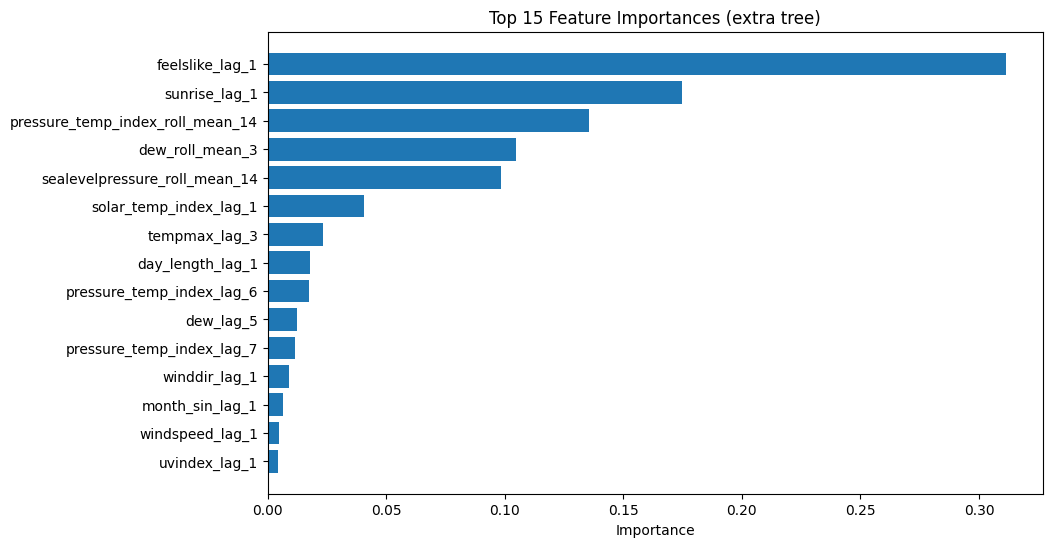

In [35]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_extra['Feature'][:15], feat_importance_extra['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (extra tree)")
plt.xlabel("Importance")
#plt.show()

In [36]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
defEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", defEx_val_metrics)

# 4. Evaluate on test
defEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", defEx_test_metrics)

# 5. Save model 
model_path = r'models/ExTree_model.pkl' 
joblib.dump(model_ex, model_path)
print(f"ExtraTree model saved to {model_path}")

# 6 Log lên ClearML
logger_extra.report_scalar("Default Metrics", "RMSE_val", defEx_val_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Default Metrics", "R2_val", defEx_val_metrics["R2"], iteration=0)
logger_extra.report_scalar("Default Metrics", "MAPE_val", defEx_val_metrics["MAPE"], iteration=0)
logger_extra.report_scalar("Default Metrics", "RMSE_test", defEx_test_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Default Metrics", "R2_test", defEx_test_metrics["R2"], iteration=0)
logger_extra.report_scalar("Default Metrics", "MAPE_test", defEx_test_metrics["MAPE"], iteration=0)


task_extra.upload_artifact("Default Metrics", {
    "Validation": defEx_val_metrics,
    "Test": defEx_test_metrics
})


Validation metrics: {'RMSE': 1.5304805182730774, 'R2': 0.9119264879175523, 'MAPE': 5.303734179674432}
Test metrics: {'RMSE': 1.379977872214333, 'R2': 0.9120112734451329, 'MAPE': 4.350115292487959}
ExtraTree model saved to models/ExTree_model.pkl


True

In [37]:
## B. Hyperparameter tuning cho ExtraTrees
def objective(trial):
    # === 1. Định nghĩa không gian hyperparameter ===
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),       # default = 100
        'max_depth': trial.suggest_int('max_depth', 5, 50),                # default = None
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),# default = 2
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),   # default = 1
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.3), # default = 0
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': False, # default = False
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100, 1000),   # default = None
        'random_state': 42,
        'n_jobs': -1
    }

    # === 2. TimeSeriesSplit CV ===
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # === 3. Train model ===
        model = ExtraTreesRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)  # bạn có hàm evaluate riêng rồi
        rmse_scores.append(metrics['RMSE'])

    mean_rmse = np.mean(rmse_scores)

    # === 4. Log kết quả lên ClearML ===
    # (a) Log giá trị RMSE của trial
    logger_extra.report_scalar(
        title='Optuna Tuning',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    # (b) Log bảng thông số
    params_table = pd.DataFrame([params])
    logger_extra.report_table(
        title=f"Trial {trial.number} Parameters",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    # === 5. Trả về giá trị cần minimize (RMSE) ===
    return mean_rmse


In [38]:
# === 3. Chạy Optuna study cho ExtraTrees ===
study_ex = optuna.create_study(
    direction='minimize',   # mục tiêu: giảm RMSE
    sampler=sampler
)

# Tiến hành tối ưu
study_ex.optimize(objective, n_trials=50, show_progress_bar=True)

# === 4. In kết quả tốt nhất ===
print("Best parameters:", study_ex.best_trial.params)
print("Best RMSE:", study_ex.best_value)


[I 2025-10-21 18:38:01,271] A new study created in memory with name: no-name-5adba6a8-8bb0-4f0c-8959-9be6a9579c32
Best trial: 0. Best value: 1.58541:   2%|▏         | 1/50 [00:05<04:33,  5.58s/it]

[I 2025-10-21 18:38:06,844] Trial 0 finished with value: 1.5854138017797699 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.04680559213273095, 'max_features': None, 'max_leaf_nodes': 641}. Best is trial 0 with value: 1.5854138017797699.


Best trial: 0. Best value: 1.58541:   4%|▍         | 2/50 [00:15<06:25,  8.03s/it]

[I 2025-10-21 18:38:16,597] Trial 1 finished with value: 1.6309389082537407 and parameters: {'n_estimators': 737, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.06370173320348284, 'max_features': None, 'max_leaf_nodes': 572}. Best is trial 0 with value: 1.5854138017797699.


Best trial: 0. Best value: 1.58541:   6%|▌         | 3/50 [00:22<05:54,  7.54s/it]

[I 2025-10-21 18:38:23,556] Trial 2 finished with value: 1.6330524234925665 and parameters: {'n_estimators': 489, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.08764339456056544, 'max_features': None, 'max_leaf_nodes': 279}. Best is trial 0 with value: 1.5854138017797699.


Best trial: 0. Best value: 1.58541:   8%|▊         | 4/50 [00:28<05:24,  7.06s/it]

[I 2025-10-21 18:38:29,888] Trial 3 finished with value: 1.5949560738132909 and parameters: {'n_estimators': 563, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.051157237106187456, 'max_features': None, 'max_leaf_nodes': 828}. Best is trial 0 with value: 1.5854138017797699.


Best trial: 4. Best value: 1.56999:  10%|█         | 5/50 [00:33<04:39,  6.22s/it]

[I 2025-10-21 18:38:34,614] Trial 4 finished with value: 1.569994640778204 and parameters: {'n_estimators': 374, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.036611470453433645, 'max_features': None, 'max_leaf_nodes': 333}. Best is trial 4 with value: 1.569994640778204.


Best trial: 4. Best value: 1.56999:  12%|█▏        | 6/50 [00:40<04:45,  6.48s/it]

[I 2025-10-21 18:38:41,594] Trial 5 finished with value: 1.8757765171330871 and parameters: {'n_estimators': 696, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.05545633665765811, 'max_features': 'sqrt', 'max_leaf_nodes': 906}. Best is trial 4 with value: 1.569994640778204.


Best trial: 4. Best value: 1.56999:  14%|█▍        | 7/50 [00:48<05:09,  7.19s/it]

[I 2025-10-21 18:38:50,235] Trial 6 finished with value: 1.746119042207378 and parameters: {'n_estimators': 638, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01356818667316142, 'max_features': 'log2', 'max_leaf_nodes': 846}. Best is trial 4 with value: 1.569994640778204.


Best trial: 4. Best value: 1.56999:  16%|█▌        | 8/50 [00:54<04:42,  6.74s/it]

[I 2025-10-21 18:38:56,004] Trial 7 finished with value: 2.177534315391798 and parameters: {'n_estimators': 421, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.2406590942262119, 'max_features': 'log2', 'max_leaf_nodes': 279}. Best is trial 4 with value: 1.569994640778204.


Best trial: 4. Best value: 1.56999:  18%|█▊        | 9/50 [00:56<03:28,  5.09s/it]

[I 2025-10-21 18:38:57,464] Trial 8 finished with value: 2.184072838426345 and parameters: {'n_estimators': 104, 'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.2313811040057837, 'max_features': 'log2', 'max_leaf_nodes': 877}. Best is trial 4 with value: 1.569994640778204.


Best trial: 4. Best value: 1.56999:  20%|██        | 10/50 [01:03<03:47,  5.69s/it]

[I 2025-10-21 18:39:04,519] Trial 9 finished with value: 1.643143158003125 and parameters: {'n_estimators': 661, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.09755499660802411, 'max_features': None, 'max_leaf_nodes': 525}. Best is trial 4 with value: 1.569994640778204.


Best trial: 4. Best value: 1.56999:  22%|██▏       | 11/50 [01:12<04:28,  6.87s/it]

[I 2025-10-21 18:39:14,048] Trial 10 finished with value: 2.080617714523775 and parameters: {'n_estimators': 951, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.16085657660932784, 'max_features': 'sqrt', 'max_leaf_nodes': 114}. Best is trial 4 with value: 1.569994640778204.


Best trial: 11. Best value: 1.48246:  24%|██▍       | 12/50 [01:16<03:39,  5.77s/it]

[I 2025-10-21 18:39:17,323] Trial 11 finished with value: 1.4824552011463772 and parameters: {'n_estimators': 294, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0027683007133353157, 'max_features': None, 'max_leaf_nodes': 582}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  26%|██▌       | 13/50 [01:17<02:50,  4.60s/it]

[I 2025-10-21 18:39:19,222] Trial 12 finished with value: 1.487073644777989 and parameters: {'n_estimators': 227, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0023922249698360085, 'max_features': None, 'max_leaf_nodes': 396}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  28%|██▊       | 14/50 [01:19<02:10,  3.63s/it]

[I 2025-10-21 18:39:20,590] Trial 13 finished with value: 1.6805013449485238 and parameters: {'n_estimators': 230, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.14228480479966227, 'max_features': None, 'max_leaf_nodes': 431}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  30%|███       | 15/50 [01:22<02:02,  3.51s/it]

[I 2025-10-21 18:39:23,836] Trial 14 finished with value: 1.4990942596442012 and parameters: {'n_estimators': 264, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.007664848443163036, 'max_features': None, 'max_leaf_nodes': 720}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  32%|███▏      | 16/50 [01:23<01:37,  2.87s/it]

[I 2025-10-21 18:39:25,234] Trial 15 finished with value: 2.1627290479281736 and parameters: {'n_estimators': 126, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.29880509680836403, 'max_features': 'sqrt', 'max_leaf_nodes': 441}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  34%|███▍      | 17/50 [01:27<01:36,  2.93s/it]

[I 2025-10-21 18:39:28,304] Trial 16 finished with value: 1.6713400749284204 and parameters: {'n_estimators': 293, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.12847659481075646, 'max_features': None, 'max_leaf_nodes': 696}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  36%|███▌      | 18/50 [01:30<01:34,  2.95s/it]

[I 2025-10-21 18:39:31,292] Trial 17 finished with value: 1.7098979817472593 and parameters: {'n_estimators': 331, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.18496255345188253, 'max_features': None, 'max_leaf_nodes': 118}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  38%|███▊      | 19/50 [01:32<01:24,  2.72s/it]

[I 2025-10-21 18:39:33,473] Trial 18 finished with value: 1.6564585682464432 and parameters: {'n_estimators': 227, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.00014212030256912592, 'max_features': 'sqrt', 'max_leaf_nodes': 422}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  40%|████      | 20/50 [01:34<01:15,  2.53s/it]

[I 2025-10-21 18:39:35,548] Trial 19 finished with value: 1.9941412809693575 and parameters: {'n_estimators': 188, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.09542294520450934, 'max_features': 'log2', 'max_leaf_nodes': 556}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  42%|████▏     | 21/50 [01:41<01:54,  3.93s/it]

[I 2025-10-21 18:39:42,762] Trial 20 finished with value: 1.661757770763162 and parameters: {'n_estimators': 845, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.11309879122991345, 'max_features': None, 'max_leaf_nodes': 212}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  44%|████▍     | 22/50 [01:43<01:37,  3.50s/it]

[I 2025-10-21 18:39:45,244] Trial 21 finished with value: 1.525617020874409 and parameters: {'n_estimators': 294, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.017434249220333264, 'max_features': None, 'max_leaf_nodes': 746}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  46%|████▌     | 23/50 [01:45<01:21,  3.01s/it]

[I 2025-10-21 18:39:47,106] Trial 22 finished with value: 1.5482295051153159 and parameters: {'n_estimators': 213, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.02700028414056692, 'max_features': None, 'max_leaf_nodes': 744}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  48%|████▊     | 24/50 [01:48<01:19,  3.04s/it]

[I 2025-10-21 18:39:50,228] Trial 23 finished with value: 1.617374984367693 and parameters: {'n_estimators': 326, 'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.07202354786212121, 'max_features': None, 'max_leaf_nodes': 984}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  50%|█████     | 25/50 [01:54<01:36,  3.86s/it]

[I 2025-10-21 18:39:56,003] Trial 24 finished with value: 1.489686610943957 and parameters: {'n_estimators': 502, 'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0038686233519529584, 'max_features': None, 'max_leaf_nodes': 627}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  52%|█████▏    | 26/50 [01:59<01:41,  4.24s/it]

[I 2025-10-21 18:40:01,141] Trial 25 finished with value: 1.5580604423525943 and parameters: {'n_estimators': 554, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.029916974116560024, 'max_features': None, 'max_leaf_nodes': 631}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  54%|█████▍    | 27/50 [02:06<01:51,  4.83s/it]

[I 2025-10-21 18:40:07,331] Trial 26 finished with value: 1.4939843253989875 and parameters: {'n_estimators': 473, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0031038109060421985, 'max_features': None, 'max_leaf_nodes': 494}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  56%|█████▌    | 28/50 [02:07<01:26,  3.95s/it]

[I 2025-10-21 18:40:09,235] Trial 27 finished with value: 1.5604387772867911 and parameters: {'n_estimators': 162, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.03129329608956821, 'max_features': None, 'max_leaf_nodes': 623}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  58%|█████▊    | 29/50 [02:12<01:26,  4.13s/it]

[I 2025-10-21 18:40:13,789] Trial 28 finished with value: 1.9430969940684015 and parameters: {'n_estimators': 381, 'max_depth': 36, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.06535035879177278, 'max_features': 'log2', 'max_leaf_nodes': 394}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  60%|██████    | 30/50 [02:18<01:32,  4.61s/it]

[I 2025-10-21 18:40:19,515] Trial 29 finished with value: 1.850938201320713 and parameters: {'n_estimators': 474, 'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.04512861932542525, 'max_features': 'sqrt', 'max_leaf_nodes': 492}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  62%|██████▏   | 31/50 [02:22<01:26,  4.53s/it]

[I 2025-10-21 18:40:23,869] Trial 30 finished with value: 1.6287918824578629 and parameters: {'n_estimators': 395, 'max_depth': 43, 'min_samples_split': 9, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.08032016366605743, 'max_features': None, 'max_leaf_nodes': 666}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  64%|██████▍   | 32/50 [02:29<01:34,  5.25s/it]

[I 2025-10-21 18:40:30,783] Trial 31 finished with value: 1.4949365120393725 and parameters: {'n_estimators': 492, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0035070938131738045, 'max_features': None, 'max_leaf_nodes': 490}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  66%|██████▌   | 33/50 [02:35<01:32,  5.46s/it]

[I 2025-10-21 18:40:36,744] Trial 32 finished with value: 1.5476932895921949 and parameters: {'n_estimators': 515, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.021488884511252103, 'max_features': None, 'max_leaf_nodes': 596}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  68%|██████▊   | 34/50 [02:42<01:35,  6.00s/it]

[I 2025-10-21 18:40:43,983] Trial 33 finished with value: 1.4982333895741047 and parameters: {'n_estimators': 589, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0020387716606042215, 'max_features': None, 'max_leaf_nodes': 366}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  70%|███████   | 35/50 [02:51<01:42,  6.86s/it]

[I 2025-10-21 18:40:52,878] Trial 34 finished with value: 1.5881009467398282 and parameters: {'n_estimators': 798, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0470375501463896, 'max_features': None, 'max_leaf_nodes': 484}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  72%|███████▏  | 36/50 [02:55<01:25,  6.07s/it]

[I 2025-10-21 18:40:57,099] Trial 35 finished with value: 1.5816020131977413 and parameters: {'n_estimators': 428, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.04371875188115536, 'max_features': None, 'max_leaf_nodes': 554}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  74%|███████▍  | 37/50 [02:59<01:07,  5.20s/it]

[I 2025-10-21 18:41:00,275] Trial 36 finished with value: 1.5439504370359274 and parameters: {'n_estimators': 348, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.022605842643695483, 'max_features': None, 'max_leaf_nodes': 312}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  76%|███████▌  | 38/50 [03:02<00:57,  4.81s/it]

[I 2025-10-21 18:41:04,166] Trial 37 finished with value: 1.5991819596006187 and parameters: {'n_estimators': 460, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.056776761773990075, 'max_features': None, 'max_leaf_nodes': 225}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  78%|███████▊  | 39/50 [03:07<00:53,  4.87s/it]

[I 2025-10-21 18:41:09,182] Trial 38 finished with value: 1.5711270331197087 and parameters: {'n_estimators': 588, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.03742259445670653, 'max_features': None, 'max_leaf_nodes': 672}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  80%|████████  | 40/50 [03:11<00:45,  4.56s/it]

[I 2025-10-21 18:41:13,030] Trial 39 finished with value: 1.9575696609811584 and parameters: {'n_estimators': 517, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0700035034315539, 'max_features': 'log2', 'max_leaf_nodes': 791}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  82%|████████▏ | 41/50 [03:17<00:43,  4.89s/it]

[I 2025-10-21 18:41:18,666] Trial 40 finished with value: 1.7168311914334136 and parameters: {'n_estimators': 639, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.19377327228181282, 'max_features': None, 'max_leaf_nodes': 512}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  84%|████████▍ | 42/50 [03:23<00:41,  5.19s/it]

[I 2025-10-21 18:41:24,558] Trial 41 finished with value: 1.521174103327739 and parameters: {'n_estimators': 510, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.012653844616283907, 'max_features': None, 'max_leaf_nodes': 463}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  86%|████████▌ | 43/50 [03:29<00:39,  5.63s/it]

[I 2025-10-21 18:41:31,219] Trial 42 finished with value: 1.5034182945705887 and parameters: {'n_estimators': 439, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.006771096232065347, 'max_features': None, 'max_leaf_nodes': 592}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  88%|████████▊ | 44/50 [03:40<00:43,  7.23s/it]

[I 2025-10-21 18:41:42,191] Trial 43 finished with value: 1.497456377374578 and parameters: {'n_estimators': 744, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0012975198213144822, 'max_features': None, 'max_leaf_nodes': 372}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  90%|█████████ | 45/50 [03:45<00:32,  6.55s/it]

[I 2025-10-21 18:41:47,137] Trial 44 finished with value: 1.540061533192474 and parameters: {'n_estimators': 400, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.02039147945483578, 'max_features': None, 'max_leaf_nodes': 531}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  92%|█████████▏| 46/50 [03:48<00:21,  5.34s/it]

[I 2025-10-21 18:41:49,665] Trial 45 finished with value: 1.8827187825165854 and parameters: {'n_estimators': 272, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.053644605416695385, 'max_features': 'sqrt', 'max_leaf_nodes': 587}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  94%|█████████▍| 47/50 [03:49<00:12,  4.16s/it]

[I 2025-10-21 18:41:51,061] Trial 46 finished with value: 1.5733773239217868 and parameters: {'n_estimators': 143, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.03393078476545705, 'max_features': None, 'max_leaf_nodes': 338}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  96%|█████████▌| 48/50 [03:55<00:09,  4.52s/it]

[I 2025-10-21 18:41:56,417] Trial 47 finished with value: 1.5189168968017275 and parameters: {'n_estimators': 572, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.013299461767489165, 'max_features': None, 'max_leaf_nodes': 453}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246:  98%|█████████▊| 49/50 [03:57<00:04,  4.02s/it]

[I 2025-10-21 18:41:59,273] Trial 48 finished with value: 2.212364253244691 and parameters: {'n_estimators': 362, 'max_depth': 39, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.2888848303308986, 'max_features': 'log2', 'max_leaf_nodes': 402}. Best is trial 11 with value: 1.4824552011463772.


Best trial: 11. Best value: 1.48246: 100%|██████████| 50/50 [04:05<00:00,  4.91s/it]

[I 2025-10-21 18:42:06,671] Trial 49 finished with value: 1.6559997468545042 and parameters: {'n_estimators': 689, 'max_depth': 36, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.11134486647164177, 'max_features': None, 'max_leaf_nodes': 527}. Best is trial 11 with value: 1.4824552011463772.
Best parameters: {'n_estimators': 294, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0027683007133353157, 'max_features': None, 'max_leaf_nodes': 582}
Best RMSE: 1.4824552011463772


In [39]:
# === 4 Log kết quả tổng hợp ===
task_extra.upload_artifact("Best Parameters", study_ex.best_trial.params)

# Fit lại mô hình với best params
best_model_ex = ExtraTreesRegressor(**study_ex.best_trial.params)
best_model_ex.fit(X_train, y_train)

# Predict
y_pred_val = best_model_ex.predict(X_val)
y_pred_test = best_model_ex.predict(X_test)

# Evaluate on validation
bestEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", bestEx_val_metrics)

# Evaluate on test
bestEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", bestEx_test_metrics)


# 6 Log lên ClearML
logger_extra.report_scalar("Best Metrics", "RMSE_val", bestEx_val_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Best Metrics", "R2_val", bestEx_val_metrics["R2"], iteration=0)
logger_extra.report_scalar("Best Metrics", "MAPE_val", bestEx_val_metrics["MAPE"], iteration=0)
logger_extra.report_scalar("Best Metrics", "RMSE_test", bestEx_test_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Best Metrics", "R2_test", bestEx_test_metrics["R2"], iteration=0)
logger_extra.report_scalar("Best Metrics", "MAPE_test", bestEx_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task_extra.upload_artifact("Best Metrics", {
    "Validation": bestEx_val_metrics,
    "Test": bestEx_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_ExTree_model.pkl' 
joblib.dump(best_model_ex, model_path)
print(f"RandomForest model saved to {model_path}")
task_extra.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': 1.4781760169477107, 'R2': 0.9178434853559763, 'MAPE': 5.106336161163009}
Test metrics: {'RMSE': 1.351677982332345, 'R2': 0.9155831259499977, 'MAPE': 4.251549843957973}
RandomForest model saved to models/Tuning_ExTree_model.pkl


True

In [40]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig2 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study_ex.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_extra.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig2,
    iteration=len(study_ex.trials)
)
plt.close(fig2)


In [42]:
vis.plot_parallel_coordinate(study_ex)

In [43]:
vis.plot_slice(study=study_ex)

In [44]:
vis.plot_param_importances(study=study_ex)

In [ ]:
task_extra.close()

: 